# Customer Review Analysis

# Goal
Create a Notebook to conduct sentiment analysis on customer writen reviews for a hotel chain utilizing pre-trained OCI AI-Language Service and then visualize the outputs to generate business insights.

# Introduction
"Customer Review Analysis" is a process of analyzing customer reviews, which are written feedback given by customers about a product or service they have used. The goal of customer review analysis is to understand the opinions and perceptions of customers about the product or service, and identify any patterns or trends that may exist. This information can be used to improve the product or service and increase customer satisfaction.

The analysis is usually done by using Natural Language Processing (NLP) techniques to extract insights, sentiment analysis to identify the overall sentiment of the reviews, and text classification to identify the main topics of reviews. The insights gained from customer review analysis can be used to improve product design, pricing, marketing, and customer service.

### What is AI-Language Services?
OCI Language Service provides suite of services to distill a deeper understanding of opinions with sentiment analysis, identify key phrases and extract named entities such as people, places and organizations to understand common subjects and patterns. You can use out of the box pre-trained models and also customize the models to suite a specific domain. OCI Language Service key features:

1. __Pre-Trained Models:__ OCI Language pre-trained APIs uses AI models trained for most common use cases.
    1. Sentiment Analysis: Identifies sentiment at the document, sentence and aspect level.
    2. Named Entity Recognition: Identifies common entities, people, places, locations, email, and so on.
    3. Key Phrase Extraction: Identify the most salient talking points in your text.
    4. Language Detection: Detects languages based on the given text, and includes a confidence score.
    4. Text Classification: Identifies the document category and subcategory that the text belongs to.
2. __Custom Models:__ OCI Language custom models enables you to customize Text Classification and Named Entity Recognition with your own data
    1. Custom Text Classification: Enables you to build a custom AI model to automatically classify text into a set of classes you pre-define, both single label and multi-label custom text classification is supported.
    2. Custom Named Entity Recognition: Enables you to build a model to identify domain-specific entities that are unique to your business or industry vertical.
3. __Text Translation:__ OCI Language now provides an API to automatically translate text across 21 languages.

### __In this notebook we are using pre-trained models for sentiment analysis (1.A in the list above).__
Please note that as part of the sentiment analysis, the service has to touch on other parts such as 1.B and 1.C as well.

# Notebook Setup and Package Imports 

In [1]:
# Install packages used in this notebook all-at-once
# !pip install -r requirements.txt

# Alternatively, you can install the specific ones you know missing
# !pip install pandas --user -feature=2020-resolver
# !pip install ipymarkup --user -feature=2020-resolver
# !pip install matplotlib --user -feature=2020-resolver
# !pip install seaborn --user -feature=2020-resolver 
# !pip install wordcloud --user -feature=2020-resolver
# !pip install oci --user -feature=2020-resolver
# !pip install ipywidgets --user -feature=2020-resolver
# !pip install IPython --user -feature=2020-resolver
# !pip install folium --user -feature=2020-resolver
# !pip install branca --user -feature=2020-resolver 
# !pip install wordcloud --user -feature=2020-resolver
# !pip install ipymarkup --user -feature=2020-resolver 
# !pip install session_info --user -feature=2020-resolver


In [2]:
# Import packages
import os
import oci
import numpy as np
import pandas as pd
from ipymarkup import show_box_markup
from ipymarkup.palette import palette, GREEN, BLUE, RED
from matplotlib import pyplot as plt
import seaborn as sns
from branca.colormap import linear
import folium
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets
from IPython.core.display import display

from check_and_treat_record_size import record_size_modifier
from call_ai_language_service import CallAILanguage

import session_info
session_info.show()

# In case of any import errors, uncomment associated packages in the previous line and rerun

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
# Useful environment Variables if running on OCI
# print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
# print(os.environ["PROJECT_OCID"])
# print(os.environ["USER_OCID"])
# print(os.environ["TENANCY_OCID"])
# print(os.environ["NB_REGION"])

### Read the data
This notebook uses a CSV dataset about a hotel chain. Guests (customers) have written text review for each hotel facility located across the United States.

In [5]:
HotelData = pd.read_csv('data\OAC_Hotel_reviews.csv')
HotelData.head(5)

,Review ID,Hotel Name,Hotel Address,Hotel City,Hotel Zip,Hotel State,Latitude,Longitude,Review Date,Review Rating,Review Text,Review Length,Review Title,Reviewer,Reviewer State
0,4136,Soft Beds,5175 Carmichael Rd,Montgomery,36106,AL,32.359833,-86.217384,10/31/2014,2.0,"Arrived early, but room was not ready. Was dis...",322,Could be better,Yorkresident,AR
1,4140,Soft Beds,5175 Carmichael Rd,Montgomery,36106,AL,32.359833,-86.217384,1/3/2014,3.0,Good motel for the price (50). Was traveling t...,326,Worn but cheap and clean!,Bweime1,LA
2,2320,Lewis Radio Beds,1100 Lewis River Rd,Woodland,98674,WA,45.907060,-122.740290,12/13/2014,4.0,The rooms were comparible to those at hotel/mo...,247,"Nice room, reasonable rates.",Ks60,TN
3,4259,Sunshine Beds & Suites Bay City,3959 Traxler Ct,Bay City,48706,MI,43.625193,-83.933687,7/26/2014,4.0,Budget-minded travelers appreciate amenities l...,602,Good nights rest,Robyn Galbos,KY
4,1366,Budget Beds,316 E 3rd St,Owensboro,42303,KY,37.773652,-87.107953,10/21/2014,2.0,Editorial Review by Citysearch Editors Economy...,159,Rude,Contributor,MO


In [9]:
# First ## records for testing
data = HotelData.head(4500)

In [7]:
print('Select the following two columns:')
review_id = widgets.Dropdown(options=data.columns,
                             description='Review IDs:',    
                             value=None,
                             disabled=False,)
review_text = widgets.Dropdown(options=data.columns, 
                               description='Review Text:',
                               value=None,
                               disabled=False,)
box = widgets.HBox([review_id, review_text])
display(box)

Select the following two columns:


In [10]:
# Make sure the correct columns are selected
if review_id.value is None or review_text.value is None:
    raise Exception('Please select the appropriate columns in the previous cell')

In [11]:
df = data[[review_id.value, review_text.value]].reset_index(drop=True)

#### TODO Specify your compartmentId here
In order to use OCI AI Services, you need to have an OCI account attached to a cloud tenancy in which you may have several compartments with unique IDs. 

In [12]:
# compartment_id = '<your unique COMPARTMENT_ID must be placed here>'
compartment_id = '<Enter your own OCI compartment ID>'


# OCI Language Service Processes

### Sentiment Analysis
Sentiment analysis can be used to gauge the mood or the tone of text.

Sentiment analysis analyzes the subjective information in an expression. For example, opinions, appraisals, emotions, or attitudes toward a topic, person, or entity. Expressions are classified, with a confidence score, as positive, negative, or neutral.

The Language service sentiment analysis uses natural language processing (NLP). The service understands the text, returns positive, neutral, mixed, and negative sentiments, and a confidence score. It supports both sentence and aspect-based sentiment analysis.


#### Aspect-Based Sentiment Analysis
Aspect-Based Sentiment Analysis (ABSA) extracts the individual aspects in the input document and classifies each of the aspects into one of the polarity classes: positive, negative, mixed, and neutral. With the predicted sentiment for each aspect, the Language API also provides a confidence score for each of the classes, and their corresponding offsets in the input.

Confidence scores closer to 1 indicate a higher confidence in the label's classification, while lower scores indicate lower confidence score. The range of the confidence score for each class is between 0–1, and the cumulative scores of all the four classes sum to 1.

For example, a restaurant review that says "Food is marginal, but the service is so bad.” contains positive sentiment toward the food aspect. Also, it has a strong negative sentiment toward the service aspect. Classifying the overall sentiment as negative would neglect the fact that food was good. ABSA addresses this problem by referring to an aspect as an attribute (or component) of an entity. Also, the screen of a phone or the picture quality of a camera.

If the input data is "I had a good day at work today", then a single aspect day is identified with 100% positive, 0% neutral, 0% mixed, and 0% negative sentiments.


#### Sentence Level Sentiment Analysis
The Language service also provides sentence level sentiment with confidence scores for each sentence in the text. Based on the use case, you can select either sentence or document sentiment, or ABSA, or both. For example, in a customer feedback analytics scenario, you may want to identify sentences that need human review for further action.

#### Use Cases
Some business use cases are:
* Brand monitoring
* Monitoring market research
* Employee feedback analysis
* Customer reviews and emails analysis
* Product surveys

__Learn more about sentiment analysis <a href="https://docs.cloud.oracle.com/iaas/language/using/pretrain-models.htm#sentiment">here</a>.__



In [13]:
# Add an Aspect_Level column where we will store the aspect for each review
df['Aspect_Level'] = ""

# Add a column where we will store the sentiment at sentence level for each review
df['Sentence_Level'] = ""

# Add a column where we will store the overall sentiment for the entire review (a.k.a document level)
df['Document_Level'] = ""

df.head()

,Review ID,Review Text,Aspect_Level,Sentence_Level,Document_Level
0,4136,"Arrived early, but room was not ready. Was dis...",,,
1,4140,Good motel for the price (50). Was traveling t...,,,
2,2320,The rooms were comparible to those at hotel/mo...,,,
3,4259,Budget-minded travelers appreciate amenities l...,,,
4,1366,Editorial Review by Citysearch Editors Economy...,,,


## Initialize the language service client

In [14]:
# Create Language service client with user config default values.
ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())
ai_client.base_client.timeout = 300

### Record Size Modification
Prior to calling the AI-Language service, the records size must be checked not to exceed the system limitation of 5,000 characters.
if the length of the text column in a row is more than the maximum limit, the code breaks the text into multiple rows with a maximum length characters, and adds these broken rows to a list of broken_rows.
If there are any broken_rows, the code asks for your consent to apply the breakdown on all the marked records.
If the user inputs "yes", the code appends the broken_rows to the original DataFrame and returns the updated DataFrame.

In [15]:
record_size_modifier(df=df,
           idx=review_id.value,
           text=review_text.value)

,Review ID,Review Text,Aspect_Level,Sentence_Level,Document_Level
0,4136,"Arrived early, but room was not ready. Was dis...",,,
1,4140,Good motel for the price (50). Was traveling t...,,,
2,2320,The rooms were comparible to those at hotel/mo...,,,
3,4259,Budget-minded travelers appreciate amenities l...,,,
4,1366,Editorial Review by Citysearch Editors Economy...,,,
...,...,...,...,...,...
4495,1015,Our air conditioning did not cool down the roo...,,,
4496,1364,There is construction going on. We were there ...,,,
4497,1335,this hotel Is the nastiest grossest place. und...,,,
4498,4223,Hotel was very clean and staff was friendly. B...,,,


### Call AI-Language for Sentiment Analysis in Batch

This function uses the batching capability of OCI Language to efficiently get entities sentiment for all the records.
While it is a bit more complicated than calling the single record API, it is much more efficient than sending one record at a time, and the operation completes much faster.

The following steps take place in that method.
1. It computes the maximum number of records for each batch, and generates a list of batches
2. It sends the batches to be scored to OCI Language
3. For each record, it writes the information back in the dataframe, in the respecting columns.

In [16]:
CallAILanguage(df=df,
               compartment_id=compartment_id,
               ai_client=ai_client,
               idx=review_id.value,
               text=review_text.value).get_sentiment()

  0%|          | 0/63 [00:00<?, ?it/s]

61 records processed so far.
161 records processed so far.
254 records processed so far.
335 records processed so far.
411 records processed so far.
485 records processed so far.
562 records processed so far.
655 records processed so far.
731 records processed so far.
799 records processed so far.
863 records processed so far.
944 records processed so far.
1016 records processed so far.
1081 records processed so far.
1150 records processed so far.
1207 records processed so far.
1274 records processed so far.
1345 records processed so far.
1415 records processed so far.
1491 records processed so far.
1561 records processed so far.
1629 records processed so far.
1694 records processed so far.
1761 records processed so far.
1828 records processed so far.
1891 records processed so far.
1966 records processed so far.
2038 records processed so far.
2110 records processed so far.
2178 records processed so far.
2240 records processed so far.
2314 records processed so far.
2377 records processe

In [17]:
df.head(3)

,Review ID,Review Text,Aspect_Level,Sentence_Level,Document_Level
0,4136,"Arrived early, but room was not ready. Was dis...","[{\n ""length"": 4,\n ""offset"": 19,\n ""scores...","[{\n ""length"": 38,\n ""offset"": 0,\n ""scores...","[{'scores': {'Mixed': 0.14016223, 'Negative': ..."
1,4140,Good motel for the price (50). Was traveling t...,"[{\n ""length"": 5,\n ""offset"": 5,\n ""scores""...","[{\n ""length"": 30,\n ""offset"": 0,\n ""scores...","[{'scores': {'Negative': 0.3270383, 'Positive'..."
2,2320,The rooms were comparible to those at hotel/mo...,"[{\n ""length"": 5,\n ""offset"": 4,\n ""scores""...","[{\n ""length"": 84,\n ""offset"": 0,\n ""scores...","[{'scores': {'Mixed': 0.2229901, 'Positive': 0..."


## Post Processing 

#### Aspect Level

In [18]:
# build out a data frame of all the aspects and their sentiments
aspects=[]
no_of_records = len(df.index)
for row_index in range(no_of_records):
    for ai_language_output in df.iloc[row_index, df.columns.get_loc('Aspect_Level')]:
        temp_aspects = (df.iloc[row_index, df.columns.get_loc(review_id.value)],  # Review ID
                        ai_language_output.text, 
                        ai_language_output.sentiment, 
                        ai_language_output.scores)
        aspects.append(temp_aspects)
df_aspects = pd.DataFrame(aspects, 
                        columns=[review_id.value, 'Sentiment Text', 'Sentiment', 'Scores'])
df_aspects['Analysis Level'] = "Aspect Level"
# display(df_aspects)
# Normalize the 'scores' column to break it down into detailed columns
df_scores = pd.json_normalize(df_aspects['Scores'])
df_scores = df_scores.round(decimals=3)

# Combine the df_aspects and df_scores into 1 table
df_result_aspects = pd.concat([df_aspects.loc[:, df_aspects.columns != 'Scores'], df_scores], axis=1)

df_result_aspects

,Review ID,Sentiment Text,Sentiment,Analysis Level,Positive,Negative,Neutral,Mixed
0,4136,room,Negative,Aspect Level,0.001,0.990,0.000,0.009
1,4136,pool,Negative,Aspect Level,0.001,0.992,0.000,0.007
2,4136,Room,Negative,Aspect Level,0.000,0.681,0.016,0.303
3,4136,furniture,Negative,Aspect Level,0.000,0.988,0.003,0.010
4,4136,chair,Negative,Aspect Level,0.000,0.994,0.000,0.006
...,...,...,...,...,...,...,...,...
21953,4226,breakfasts,Positive,Aspect Level,0.993,0.003,0.000,0.004
21954,4226,cleanliness,Positive,Aspect Level,0.998,0.001,0.000,0.001
21955,4226,place,Positive,Aspect Level,0.692,0.010,0.000,0.299
21956,4226,elevator,Negative,Aspect Level,0.000,0.902,0.007,0.091


#### Sentence Level

In [19]:
# build out a data frame of all the sentences and their sentiments
sentences=[]
no_of_records = len(df.index)
for row_index in range(no_of_records):
    for ai_language_output in df.iloc[row_index, df.columns.get_loc('Sentence_Level')]:
        temp_sentences = (df.iloc[row_index, df.columns.get_loc(review_id.value)],  # Review ID
                        ai_language_output.text, 
                        ai_language_output.sentiment, 
                        ai_language_output.scores)
        sentences.append(temp_sentences)
df_sentences = pd.DataFrame(sentences, 
                        columns=[review_id.value, 'Sentiment Text', 'Sentiment', 'Scores'])
df_sentences['Analysis Level'] = "Sentence Level"

# Normalize the scores column to break it down into detailed columns
df_scores = pd.json_normalize(df_sentences['Scores'])
df_scores = df_scores.round(decimals=3)

# Combine the df_sentences and df_scores into 1 table
df_result_sentences = pd.concat([df_sentences.loc[:, df_sentences.columns != 'Scores'], df_scores], axis=1)

df_result_sentences

,Review ID,Sentiment Text,Sentiment,Analysis Level,Neutral,Positive,Mixed,Negative
0,4136,"Arrived early, but room was not ready.",Negative,Sentence Level,0.019,0.000,0.105,0.877
1,4136,Was disappointed to see that the pool was shut...,Negative,Sentence Level,0.104,0.000,0.147,0.749
2,4136,"Room was ok, but the furniture was worn, and o...",Negative,Sentence Level,0.028,0.000,0.274,0.698
3,4136,"Stains on the carpet, and a towel rack had bee...",Negative,Sentence Level,0.028,0.000,0.035,0.937
4,4140,Good motel for the price (50).,Positive,Sentence Level,0.107,0.678,0.117,0.099
...,...,...,...,...,...,...,...,...
19152,4223,Breakfast was very organized and they made sur...,Positive,Sentence Level,0.012,0.960,0.011,0.017
19153,4223,Didn't really appreciate housekeeping knocking...,Negative,Sentence Level,0.115,0.106,0.115,0.665
19154,4226,Complimentary dinners to breakfasts to cleanli...,Mixed,Sentence Level,0.000,0.101,0.888,0.011
19155,4226,"Stayed here for two weeks, faced no problems.",Positive,Sentence Level,0.168,0.588,0.186,0.058


#### Document Level

In [20]:
no_of_records = len(df.index)
document = []
for row_index in range(no_of_records):
    for ai_language_output in df.iloc[row_index, df.columns.get_loc('Document_Level')]:
        temp_document = (df.iloc[row_index, df.columns.get_loc(review_id.value)],  # Review ID
                        df.iloc[row_index, df.columns.get_loc(review_text.value)], # Review Text
                        ai_language_output['sentiment'], 
                        ai_language_output['scores'])
        document.append(temp_document)
df_document = pd.DataFrame(document, 
                        columns=[review_id.value, 
                                 'Sentiment Text',
                                 'Sentiment', 
                                 'Scores'])
df_document['Analysis Level'] = "Document Level"

# Normalize the scores column to break it down into detailed columns
df_scores = pd.json_normalize(df_document['Scores'])
df_scores = df_scores.round(decimals=3)

# Combine the df_document and df_scores into 1 table
df_result_document = pd.concat([df_document.loc[:, df_document.columns != 'Scores'], df_scores], axis=1)

df_result_document

,Review ID,Sentiment Text,Sentiment,Analysis Level,Mixed,Negative,Positive,Neutral
0,4136,"Arrived early, but room was not ready. Was dis...",Negative,Document Level,0.140,0.815,0.000,0.045
1,4140,Good motel for the price (50). Was traveling t...,Mixed,Document Level,0.423,0.327,0.174,0.077
2,2320,The rooms were comparible to those at hotel/mo...,Positive,Document Level,0.223,0.225,0.457,0.095
3,4259,Budget-minded travelers appreciate amenities l...,Positive,Document Level,0.073,0.007,0.723,0.197
4,1366,Editorial Review by Citysearch Editors Economy...,Neutral,Document Level,0.141,0.181,0.018,0.659
...,...,...,...,...,...,...,...,...
4495,1015,Our air conditioning did not cool down the roo...,Negative,Document Level,0.256,0.603,0.012,0.130
4496,1364,There is construction going on. We were there ...,Positive,Document Level,0.319,0.173,0.376,0.132
4497,1335,this hotel Is the nastiest grossest place. und...,Negative,Document Level,0.082,0.840,0.029,0.049
4498,4223,Hotel was very clean and staff was friendly. B...,Positive,Document Level,0.045,0.230,0.683,0.042


In [21]:
# Union the previous tables into 1 long dataframe
results = pd.concat([df_result_sentences, df_result_aspects, df_result_document])
results

,Review ID,Sentiment Text,Sentiment,Analysis Level,Neutral,Positive,Mixed,Negative
0,4136,"Arrived early, but room was not ready.",Negative,Sentence Level,0.019,0.000,0.105,0.877
1,4136,Was disappointed to see that the pool was shut...,Negative,Sentence Level,0.104,0.000,0.147,0.749
2,4136,"Room was ok, but the furniture was worn, and o...",Negative,Sentence Level,0.028,0.000,0.274,0.698
3,4136,"Stains on the carpet, and a towel rack had bee...",Negative,Sentence Level,0.028,0.000,0.035,0.937
4,4140,Good motel for the price (50).,Positive,Sentence Level,0.107,0.678,0.117,0.099
...,...,...,...,...,...,...,...,...
4495,1015,Our air conditioning did not cool down the roo...,Negative,Document Level,0.130,0.012,0.256,0.603
4496,1364,There is construction going on. We were there ...,Positive,Document Level,0.132,0.376,0.319,0.173
4497,1335,this hotel Is the nastiest grossest place. und...,Negative,Document Level,0.049,0.029,0.082,0.840
4498,4223,Hotel was very clean and staff was friendly. B...,Positive,Document Level,0.042,0.683,0.045,0.230


#### Join the results back to the original data to construct 1 large table of texts, their sentiments and attributes

In [22]:
df_final_res = pd.merge(
                        data,
                        results,
                        how="right",
                        on=review_id.value,
                        left_index=False,
                        right_index=False,
                        sort=True,
                        copy=True,
                        indicator=False)
df_final_res

,Review ID,Hotel Name,Hotel Address,Hotel City,Hotel Zip,Hotel State,Latitude,Longitude,Review Date,Review Rating,...,Review Title,Reviewer,Reviewer State,Sentiment Text,Sentiment,Analysis Level,Neutral,Positive,Mixed,Negative
0,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,5/6/2016,1.0,...,BED BUGS!!!! Dirty rooms and run down,A Traveler,IA,Bed Bugs!!,Negative,Sentence Level,0.000,0.000,0.000,1.000
1,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,5/6/2016,1.0,...,BED BUGS!!!! Dirty rooms and run down,A Traveler,IA,We stayed here on 5/6/16 in room 309.,Neutral,Sentence Level,0.802,0.045,0.039,0.114
2,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,5/6/2016,1.0,...,BED BUGS!!!! Dirty rooms and run down,A Traveler,IA,Around 9:00 I decided to get the kids ready fo...,Neutral,Sentence Level,0.894,0.019,0.058,0.029
3,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,5/6/2016,1.0,...,BED BUGS!!!! Dirty rooms and run down,A Traveler,IA,"Between the mattress pad and the fitted sheet,...",Negative,Sentence Level,0.128,0.000,0.039,0.832
4,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,5/6/2016,1.0,...,BED BUGS!!!! Dirty rooms and run down,A Traveler,IA,I called the front desk and told them there wa...,Negative,Sentence Level,0.089,0.000,0.027,0.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45610,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,5/15/2016,5.0,...,"Great location in the center of the city,",Amy Murphy,IL,Easy to get some food and services close by.,Positive,Sentence Level,0.090,0.853,0.035,0.022
45611,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,5/15/2016,5.0,...,"Great location in the center of the city,",Amy Murphy,IL,facilities,Positive,Aspect Level,0.000,0.993,0.007,0.000
45612,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,5/15/2016,5.0,...,"Great location in the center of the city,",Amy Murphy,IL,food,Positive,Aspect Level,0.000,0.996,0.000,0.004
45613,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,5/15/2016,5.0,...,"Great location in the center of the city,",Amy Murphy,IL,services,Positive,Aspect Level,0.001,0.994,0.000,0.005


### Quick High level Validation
Let's check whether the sentiment output of OCI AI-Language is actually consistent with the customer ratings.

The expectation is to see a strong positive correlation between sentiments and ratings, so that hotels with high average ratings, should also receive high average positive sentiment score.

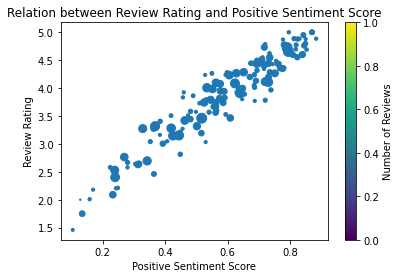

In [23]:
# Aggregate the data at the desired level
plt_data = (df_final_res.groupby(by=['Hotel Name'])
                           .agg({review_id.value: pd.Series.nunique, 'Positive': 'mean', 'Review Rating': 'mean'})
                           .reset_index(drop=True))
# extract the columns of interest
x = plt_data['Positive']
y = plt_data['Review Rating']
s = plt_data[review_id.value]

# create a scatter plot
plt.scatter(x, y, s=s)

# set the plot title and axis labels
plt.title('Relation between Review Rating and Positive Sentiment Score')
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Review Rating')

# show the colorbar for the size scale
plt.colorbar(label='Number of Reviews')

# display the plot
plt.show()

# Visualization
In this section we aim for visualizing the outputs received from the AI-Language Service to gain some insights on the sentiments of customer reviews.

In [24]:
# Let's display a few records with the detected sentiment highlighted at sentence level

def position_hilighter(df, sentiment_level, no_of_records, idx, text):
    for row_index in range(no_of_records):
        # Print the Review ID
        print('\n Review ID: ', df.iloc[row_index, df.columns.get_loc(idx)])

        # Span is used as the list of locations to be highlighted
        spans=[]
        for ai_language_output in df.iloc[row_index, df.columns.get_loc(sentiment_level)]: 
            # ai_language_output is in JSON format which we saved it all in individual cells. Now, we can read the values based on their titles
            spans += [(ai_language_output.offset,  # The position of starting character of the sentence/aspect.
                       ai_language_output.offset + ai_language_output.length,  # Starting position plus the length of the sentence/aspect would determine the ending position
                       ai_language_output.sentiment)]    

        # Highlight the identified area in the 'text' column
        show_box_markup(df.iloc[row_index, df.columns.get_loc(text)],
                        spans,
                        palette=palette(Positvie=GREEN, Negative=RED, Neutral=BLUE))


position_hilighter(df=df,
                   sentiment_level="Sentence_Level",
                   no_of_records=5,
                   idx=review_id.value,
                   text=review_text.value)


 Review ID:  4136



 Review ID:  4140



 Review ID:  2320



 Review ID:  4259



 Review ID:  1366


In [25]:
# Let's display a few records with the detected sentiment highlighted at aspect level

position_hilighter(df=df,
                   sentiment_level="Aspect_Level",
                   no_of_records=5,
                   idx=review_id.value,
                   text=review_text.value)


 Review ID:  4136



 Review ID:  4140



 Review ID:  2320



 Review ID:  4259



 Review ID:  1366


In [26]:
def small_batch():
    """ Get sentiment for a small number of records
    
    This function would enable you to feed a few records (documents) and get their sentiment quickly without having to feed the data through csv or a database storage
    
    """
    texts = []
    num_texts = int(input("How many texts would you like to analyze? "))
    for i in range(num_texts):
        text = input(f"Please enter text {i+1}: ")
        texts.append(text)
    mini_df = pd.DataFrame(texts, columns=['text'])
    mini_df['id'] = np.arange(len(mini_df)) + 1

    # Add respective columns to store the sentiment outputs 
    mini_df['Aspect_Level'] = ""
    mini_df['Sentence_Level'] = ""
    mini_df['Document_Level'] = ""

    # Call record size modifier (as seen before in this notebook)
    record_size_modifier(df=mini_df,
               idx='id',
               text='text')

    # Call record size modifier (as seen before in this notebook)
    CallAILanguage(df=mini_df,
                   compartment_id=compartment_id,
                   ai_client=ai_client,
                   idx='id',
                   text='text').get_sentiment()

    # Highlight the sentiment outputs at Aspect and Sentence levels
    no_of_records = len(mini_df)
    position_hilighter(df=mini_df,
                       sentiment_level="Aspect_Level",
                       no_of_records=no_of_records,
                       idx='id',
                       text='text')
    position_hilighter(df=mini_df,
                       sentiment_level="Sentence_Level",
                       no_of_records=no_of_records,
                       idx='id',
                       text='text')

### Small Batch Sentiment
If interested to manually provide a few texts (documents) and quickly check out the sentiment results, please uncomment the next cell.

In [28]:
small_batch()

How many texts would you like to analyze? 2
Please enter text 1: This is a positive sample text
Please enter text 2: This is a negative sample text


  0%|          | 0/1 [00:00<?, ?it/s]

2 records processed so far.

 Review ID:  1



 Review ID:  2



 Review ID:  1



 Review ID:  2


### Find aspect with strongest positive and negative polarity

In [29]:
# transform and aggregate the data frame to find the top occurring Aspects and Sentiments.
top_aspects = (df_result_aspects.groupby(by=['Sentiment Text', 'Sentiment'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
no_of_top_aspects=10
top_aspects.iloc[:no_of_top_aspects,:]

#Top Positive Aspects
no_of_top_aspects=5
top_aspects_positive = top_aspects[top_aspects['Sentiment'] == 'Positive']
display(top_aspects_positive.iloc[:no_of_top_aspects, :])

,Sentiment Text,Sentiment,Frequency
0,staff,Positive,996
1,room,Positive,955
2,hotel,Positive,881
4,breakfast,Positive,526
5,rooms,Positive,461


In [30]:
#Top Negative Aspects
no_of_top_aspects=5
top_aspects_negative = top_aspects[top_aspects['Sentiment'] == 'Negative']
display(top_aspects_negative.iloc[:no_of_top_aspects, :])

,Sentiment Text,Sentiment,Frequency
3,room,Negative,593
9,hotel,Negative,303
17,breakfast,Negative,147
20,rooms,Negative,132
24,bed,Negative,95


### Display word clouds using sentiment and frequency

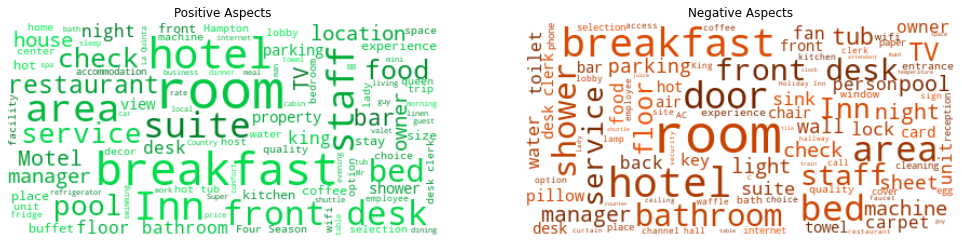

In [31]:
content_pos=''
content_neg=''
for i in top_aspects_positive['Sentiment Text'][0:len(top_aspects_positive['Sentiment Text'])+1]:
    content_pos = content_pos + i + " "
for i in top_aspects_negative['Sentiment Text'][0:len(top_aspects_negative['Sentiment Text'])+1]:
    content_neg = content_neg + i + " "
    
colour_dict = {
    'green':140,
    'blue': 220,
    'red': 20
}
def red_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['red'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
def green_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['green'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

#Plotting Word Cloud
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= green_fn).generate(content_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= red_fn).generate(content_neg)
plt.figure(figsize=(17,14))
# plt.figure()
plt.subplot(1, 2, 1)
plt.title("Positive Aspects")
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Negative Aspects")
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

the fact that "room" or "breakfast" are standing out in both positive and negative reviews indicates an __inconsistency__ in the service provided by different hotel locations/brands. This is a valuable observation that can provide insights into areas for improvement. 
<br><br>
To further analyze and investigate, we could drill down and slice the data to look into specific brands/locations to which brands/locations are causing the inconsistency. 

### Negative vs Positive Score by Hotel Name
Let's see how hotels rank considering their all the positive nad negative reviews at both Aspect and Sentence level.

In [32]:
# Aggregate the data
hotel_names = df_final_res['Hotel Name'].unique()
negative_reviews = (df_final_res[['Hotel Name', 'Negative']].groupby(by=['Hotel Name'])
                           .sum('Negative')
                           .reset_index(drop=True).rename(columns={0 : 'Sum'}))

# Make the numbers negative for negative_reviews and divide each number by subtotal to scale it and make a "Negativity Percentage Rate"
negative_reviews = [value * -1 / negative_reviews['Negative'].sum() * 100
                    for value in negative_reviews['Negative']]

positive_reviews = (df_final_res[['Hotel Name', 'Positive']].groupby(by=['Hotel Name'])
                           .sum('Positive')
                           .reset_index(drop=True).rename(columns={0 : 'Sum'}))
# Divide each number by subtotal to scale it and make a "Positivity Percentage Rate"
positive_reviews = [value / positive_reviews['Positive'].sum() * 100
                    for value in positive_reviews['Positive']]

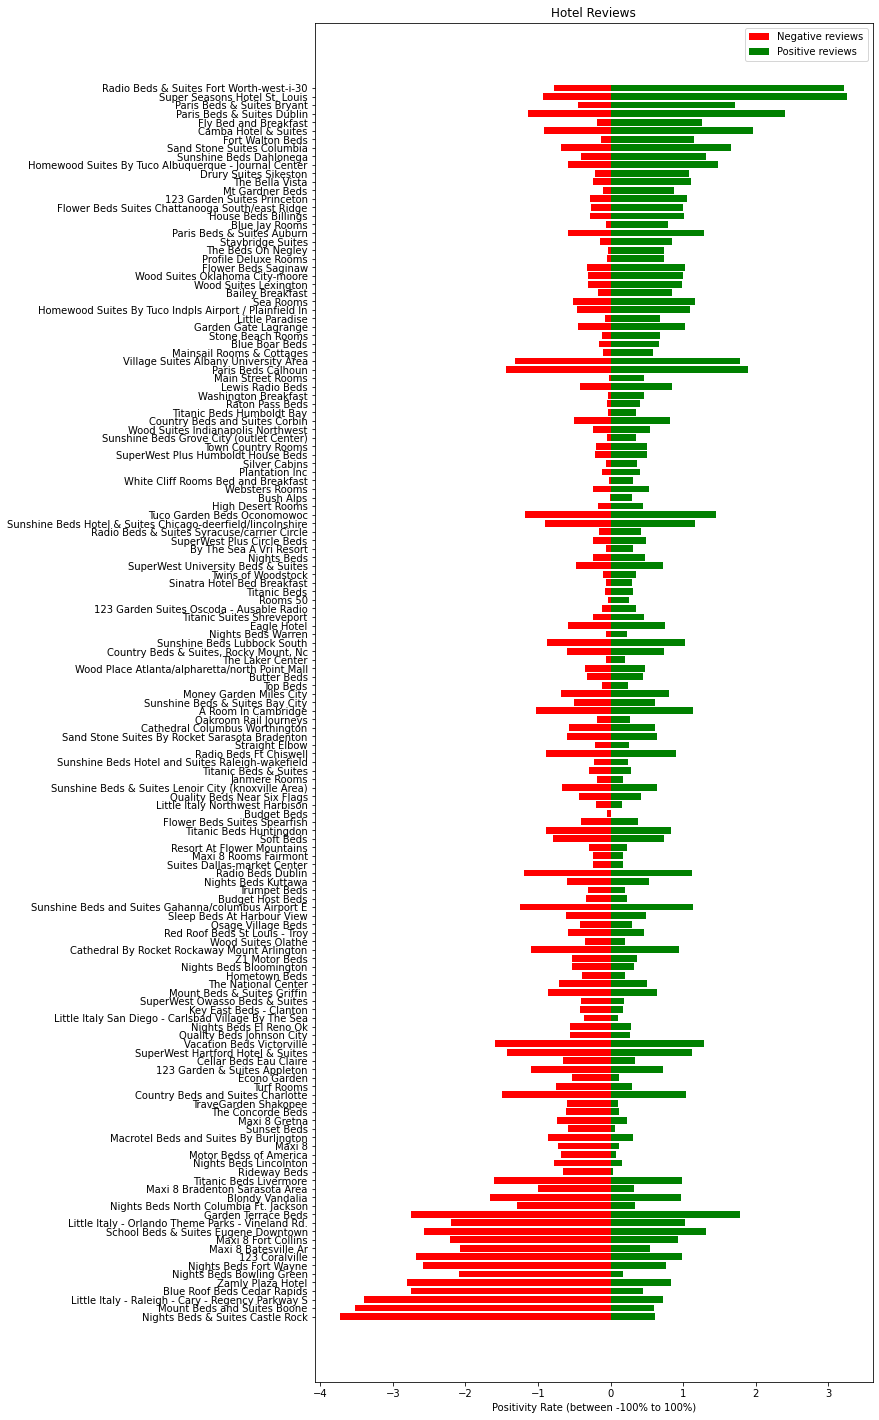

In [33]:
# To have better sorting logic, let's sort based on the difference between Positives and Negatives for each Hotel
# Calculate the difference between positive and negative reviews
diff = [p + n for p, n in zip(positive_reviews, negative_reviews)]

# Sort the data by the difference in descending order
sorted_indices = np.argsort(diff)[::-1]
hotel_names = [hotel_names[i] for i in sorted_indices]
negative_reviews = [negative_reviews[i] for i in sorted_indices]
positive_reviews = [positive_reviews[i] for i in sorted_indices]

# Calculate the positions of the bars
pos = np.arange(len(hotel_names))

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10,25))

# Plot the positive and negative reviews
ax.barh(pos, negative_reviews, align='center', color='red')
ax.barh(pos, positive_reviews, align='center', color='green')

# Set the labels and title
ax.set_xlabel('Positivity Rate (between -100% to 100%)')
ax.set_yticks(pos)
ax.set_yticklabels(hotel_names)
ax.set_title('Hotel Reviews')

# Add a legend
ax.legend(['Negative reviews', 'Positive reviews'])

# Invert the y-axis to show the bars descending from top to bottom
ax.invert_yaxis()

# Show the plot
plt.show()

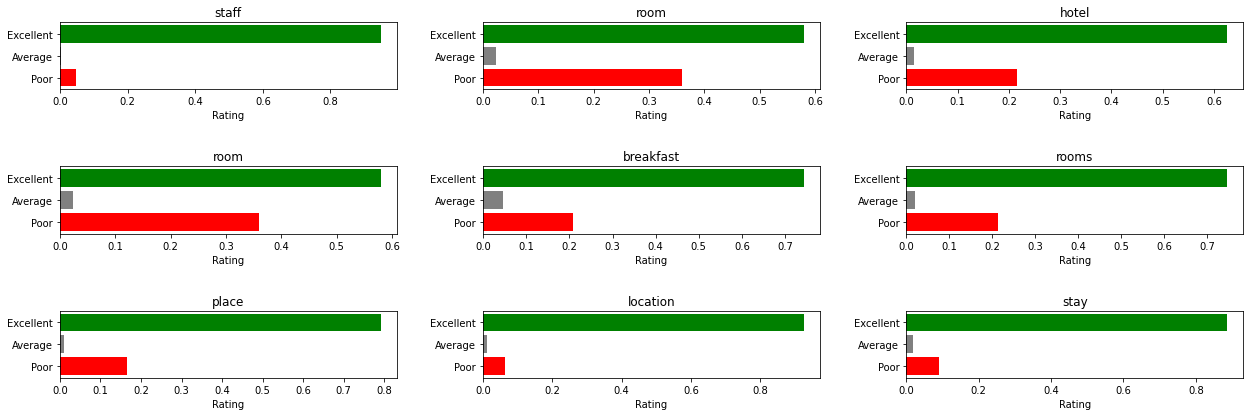

In [34]:
#Plotting the rating of top aspects detected.
plt.figure(figsize=(18,10))
all_top_aspects=[]

no_of_top_aspects = 9

for i in range(no_of_top_aspects):
    asp = top_aspects.iloc[i]['Sentiment Text']
    temp = df_result_aspects[df_result_aspects['Sentiment Text']==top_aspects.iloc[i]['Sentiment Text']]
    tot_count = temp.count()['Sentiment Text']
    excellent = temp[temp['Sentiment']=='Positive'].count()['Sentiment Text']/tot_count
    poor = temp[temp['Sentiment']=='Negative'].count()['Sentiment Text']/tot_count
    average = temp[temp['Sentiment']=='Neutral'].count()['Sentiment Text']/tot_count
    plt.subplot(5, 3, i+1)
    y=['Poor', 'Average', 'Excellent']
    x=[poor,average,excellent]
    plt.barh(y, x, color=['red', 'grey', 'green'])
    plt.xlabel("Rating") 
    plt.title(asp)
plt.tight_layout(pad=3.0)
plt.show()

### Effect of the Day-of-the-Week on Sentiment

In this chart we review whether day-of-the-week has an impact on sentiment

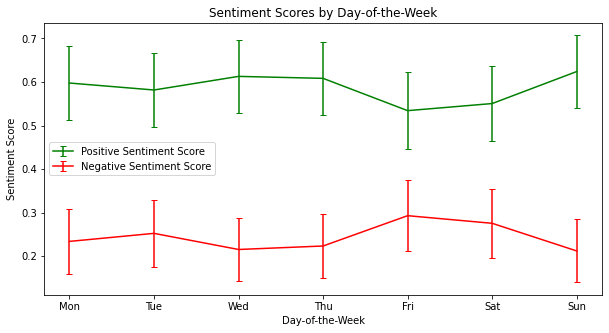

In [35]:


# convert the date column to datetime format and extract the day-of-the-week
df_final_res['Review Date'] = pd.to_datetime(df_final_res['Review Date'])
df_final_res['day_of_week'] = df_final_res['Review Date'].dt.dayofweek


# group the data by day-of-the-week and calculate the mean and standard deviation of the sentiment scores
plt_data = df_final_res.groupby('day_of_week')
sentiment_means = plt_data.mean(numeric_only=True)[['Positive', 'Mixed', 'Negative']]
sentiment_stds = plt_data.std(numeric_only=True)[['Positive', 'Mixed', 'Negative']]

# define scaling factor for error bar height
scaling_factor = 0.2

# create a line plot for the sentiment scores over the day-of-the-week, with error bars showing the standard deviation
fig, ax = plt.subplots(figsize=(10,5))
sns.set_palette("husl")
ax.errorbar(range(7), sentiment_means['Positive'], 
            yerr=sentiment_stds['Positive'] * scaling_factor, 
            label='Positive Sentiment Score', capsize=3, c='green')
ax.errorbar(range(7), sentiment_means['Negative'], 
            yerr=sentiment_stds['Negative']* scaling_factor, 
            label='Negative Sentiment Score', capsize=3, c='red')
# Uncomment if iterested to include "Mixed" sentiments
# ax.errorbar(range(7), sentiment_means['Mixed'], 
#             yerr=sentiment_stds['Mixed'] * scaling_factor, 
#             label='Mixed Sentiment Score', capsize=3, c='blue')

# set the plot title and axis labels
ax.set_title('Sentiment Scores by Day-of-the-Week')
ax.set_xlabel('Day-of-the-Week')
ax.set_ylabel('Sentiment Score')
ax.legend()

# define a list of day names
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# label the x-axis ticks with the day names
plt.xticks(range(7), day_names)

# display the plot
plt.show()


In [36]:
df_final_res

,Review ID,Hotel Name,Hotel Address,Hotel City,Hotel Zip,Hotel State,Latitude,Longitude,Review Date,Review Rating,...,Reviewer,Reviewer State,Sentiment Text,Sentiment,Analysis Level,Neutral,Positive,Mixed,Negative,day_of_week
0,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,2016-05-06,1.0,...,A Traveler,IA,Bed Bugs!!,Negative,Sentence Level,0.000,0.000,0.000,1.000,4
1,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,2016-05-06,1.0,...,A Traveler,IA,We stayed here on 5/6/16 in room 309.,Neutral,Sentence Level,0.802,0.045,0.039,0.114,4
2,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,2016-05-06,1.0,...,A Traveler,IA,Around 9:00 I decided to get the kids ready fo...,Neutral,Sentence Level,0.894,0.019,0.058,0.029,4
3,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,2016-05-06,1.0,...,A Traveler,IA,"Between the mattress pad and the fitted sheet,...",Negative,Sentence Level,0.128,0.000,0.039,0.832,4
4,1002,123 Coralville,2597 Holiday Rd,Coralville,52241,IA,41.70064,-91.60700,2016-05-06,1.0,...,A Traveler,IA,I called the front desk and told them there wa...,Negative,Sentence Level,0.089,0.000,0.027,0.885,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45610,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,2016-05-15,5.0,...,Amy Murphy,IL,Easy to get some food and services close by.,Positive,Sentence Level,0.090,0.853,0.035,0.022,6
45611,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,2016-05-15,5.0,...,Amy Murphy,IL,facilities,Positive,Aspect Level,0.000,0.993,0.007,0.000,6
45612,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,2016-05-15,5.0,...,Amy Murphy,IL,food,Positive,Aspect Level,0.000,0.996,0.000,0.004,6
45613,5873,Zamly Plaza Hotel,50 Capital Ave S W,Battle Creek,49017,MI,42.31200,-85.19201,2016-05-15,5.0,...,Amy Murphy,IL,services,Positive,Aspect Level,0.001,0.994,0.000,0.005,6


### Map of Negative Sentiment Scores
Let's see the negative sentiment scores on the map of the United States and set the size of the markers to be proportional to the number of reviews.

In [37]:
# Aggregate the data at the desired level
plt_data = (df_final_res.groupby(by=['Latitude', 'Longitude'])
                           .agg({review_id.value: pd.Series.nunique, 'Negative': 'mean'})
                           .reset_index().rename(columns={review_id.value : 'num_reviews'}))

# create a map centered on the United States
map_center = [39.8283, -98.5795]
map = folium.Map(location=map_center, zoom_start=4)

# Alternatively, create a map centered on the mean latitude and longitude of the reviews. Uncomment if interested
# map_center = [df_final_res['Latitude'].mean(), data['Longitude'].mean()]
# map = folium.Map(location=map_center, zoom_start=4)

# create a colormap that ranges from dark red for low scores to dark green for high scores
colormap = linear.PuRd_09.scale(plt_data['Negative'].min(), plt_data['Negative'].max())
    
# add a marker for each review
for i, row in plt_data.iterrows():
    sentiment_score = row['Negative']
    num_reviews = row['num_reviews']
    latitude = row['Latitude']
    longitude = row['Longitude']
    marker_color = colormap(sentiment_score)
    marker_size = num_reviews / 2  # Divided by 2 to make it a bit smaller
    marker = folium.CircleMarker([latitude, longitude], radius=marker_size, color=marker_color, fill=True, fill_color=marker_color)
    marker.add_to(map)
    
# add a title to the map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Negative Sentiment Scores by Location</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))

# display the map
map


# Conclusion
In conclusion, the OCI AI-Language service presented in this document has the potential to revolutionize the way we analyze and understand customer reviews. By leveraging natural language processing and pretrained models, this service is able to quickly and accurately identify the sentiment of a given text, regardless of its length or complexity. With the ability to call the API in batch or integrate it into existing workflows, this service has the potential to streamline customer feedback analysis for businesses of all sizes. Overall, the AI-Language service is a powerful tool for any organization looking to gain valuable insights into their customers' opinions and preferences.

### Helpful Documentations

<ul>
    <li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
    <li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
    <li><a href="https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=887">AI Services: Introduction to OCI Language</a></li>
    <li><a href="https://docs.oracle.com/en-us/iaas/data-science/using/configure-tenancy.htm">Manually Configuring Your Tenancy for Data Science</a></li>
    <li><a href="https://docs.oracle.com/en-us/iaas/tools/python/2.90.4/">Oracle Cloud Infrastructure Python SDK</a></li>

</ul>